#Zadanie 2 (7 pkt)
Celem zadania jest rozwiązanie zadania optymalizacji przy pomocy algorytmu genetycznego. Należy znaleźć minimum zadanej funkcji:
\begin{equation}
f(x) = 1.5-\exp \left\{-x_1^2-x_2^2\right\}-0.5 \exp \left\{-\left(x_1-1\right)^2-\left(x_2+2\right)^2\right\}
\end{equation}
Należy wykorzystać mechanizmy krzyżowania punktowego, mutacji oraz selekcji turniejowej. Proszę wykorzystać przygotowany szkielet i zaimplementować niezbędne metody. Opracowane oprogramowanie powinno być uniwersalne - wymiar funkcji, której minimum szukamy może być dowolny (mechanizm *args). Punktacja wygląda następująco:

*   Stworzenie obiektu klasy *Chromosome* z polem *array*, które jest wektorem aktywnych i nieaktywnych genów - **0.5 pkt**
*   Implementacja metody *decode*, która dekoduje część chromosomu (określoną przez początek (*lower_bound*) i koniec (*upper_bound*)) do postaci liczby rzeczywistej. *aoi* to zakres wartości zdekodowanej liczby rzeczywistej. Przykład: liczba 135 w postaci binarnej zapisana przy użyciu 8 bitów to 1000 0111, jeśli nasze *aoi* to [0, 1], to 135 sprowadzone do tego zakresu to 0.529. Można skorzystać z funkcji pomocniczej *min_max_norm* - **1 pkt**
*   Implementacja metody *mutation*, która przyjmuje jako argument prawdopodobieństo mutacji i zmienia wartość jedego, losowego genu na przeciwną - **0.5 pkt**
*   Implementacja metody *crossover*, która wykonuje operację krzyżowania jednopunktowego - **1 pkt**
*   Implementacja metody *eval_objective_func*, która dekoduje cały chromosom (otrzymuje się argumenty funkcji) oraz zwraca wartość funkcji celu dla tych argumentów - **1 pkt**
*   Implementacja metody *tournament_selection*, która przeprowadza selekcję turniejową - **1 pkt**
*   Implementacja metody *reproduce*, która generuje nowe pokolenie - z pewnym prawdopodobieństwem przeprowadza krzyżowanie jednopunktowe lub "przerzuca" rodziców do nowego pokolenia - **0.5 pkt**
*   Implementacja metody *run*, która wykonuje cały alorytm genetyczny dla określonej liczby pokoleń. W każdym pokoleniu należy zapisać dane osobnika z najlepszym chromosomem zdekodowane wartości x i y oraz wartość funkcji strat dla tego osobnika - **0.5 pkt**
*   Proszę, podobnie jak miało to miejsce w przypadku metody gradientowej z poprzednich zajęć, wygenerować wykres przy użyciu funkcji *plot_func* (w przypadku innego typu argumentu *trace*, funkcję można zmodyfikować. Wykres powinien przedstawiać funkcję, której minimum poszukujemy oraz punkty odpowiadające najlepszym osobnikom w danych generacjach, których kolor jest coraz jaśniejszy wraz ze zbliżaniem się do minimum. Proszę zapisać swoje wnioski, w szczególności w odniesieniu do metody gradientowej. - **1 pkt**


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
from typing import List
import copy

In [3]:
def min_max_norm(val, min_val, max_val, new_min, new_max):
  return (val - min_val) * (new_max - new_min) / (max_val - min_val) + new_min

In [4]:
class Chromosome:
  def __init__(self, length, array=None): #if array is None it should be initialized with random binary vector
    if array:
      self.array = array
    else:
      bits = [0, 1]
      self.array = random.choices(bits, k = length)
    self.length = length

  def decode(self, lower_bound, upper_bound, aoi, num_of_args):
    bits = self.array[lower_bound:upper_bound]
    bin_to_dec = int(''.join(map(str,bits)),base=2)
    max_num = 2**(self.length/num_of_args)
    result = min_max_norm(bin_to_dec, 0, max_num, aoi[0], aoi[1])
    return result

  def decode_all(self, bits_per_arg, aoi, obj_func_num_args):
    arguments = []
    for i in range(obj_func_num_args):
      bpa = bits_per_arg
      arguments.append(self.decode(bpa*i, bpa*(i+1), aoi[i], obj_func_num_args))
    return arguments

  def mutation(self, probability):
    mutate = random.random() < probability
    if mutate:
      index = random.randint(0, self.length-1)
      new_gene = int(not self.array[index])
      self.array[index] = new_gene

  def crossover(self, other: 'Chromosome'):
    index = random.randint(0, self.length-1)
    new_chromosome = self.array[:index] + other.array[index:]
    #new_chromosome2 = other.array[:index] + self.array[index:]
    return Chromosome(self.length, new_chromosome)

In [5]:
class GeneticAlgorithm:
  def __init__(self, chromosome_length, obj_func_num_args, objective_function, aoi, population_size=1000,
               tournament_size=2, mutation_probability=0.05, crossover_probability=0.8, num_steps=30):
    assert chromosome_length % obj_func_num_args == 0, "Number of bits for each argument should be equal"
    self.population_size = population_size
    self.chromosome_lengths = chromosome_length
    self.obj_func_num_args = obj_func_num_args
    self.bits_per_arg = int(chromosome_length / obj_func_num_args)
    self.objective_function = objective_function
    self.aoi = aoi
    self.tournament_size = tournament_size
    self.mutation_probability = mutation_probability
    self.crossover_probability = crossover_probability
    self.num_steps = num_steps

  def print_arguments(self, verbose):
    print('Population size       = ', self.population_size)
    print('Mutation probability  = ', self.mutation_probability)
    print('Crossover probability = ', self.crossover_probability)
    print('Num of iterations     = ', self.num_steps)
    if verbose == 2:
      print('aoi                   = ', self.aoi)
      print('Chromosome length     = ', self.chromosome_lengths)

  def eval_objective_func(self, chromosome: Chromosome):
    arguments = chromosome.decode_all(self.bits_per_arg, self.aoi, self.obj_func_num_args)
    return self.objective_function(*arguments)


  def tournament_selection(self, population: list):
    new_population = []
    for _ in range(self.population_size):
      group = random.choices(population, k = self.tournament_size)
      group = sorted(group, key=self.eval_objective_func)
      new_population.append(group[0])
    return new_population

  def reproduce(self, parents: List[Chromosome]):
    new_population = []
    for _ in range(self.population_size):
      crossover = self.crossover_probability > random.random()
      index1 = random.randint(0,len(parents)-1)
      x = parents[index1]
      if crossover:
        index2 = random.randint(0,len(parents)-1)
        x = parents[index1].crossover(parents[index2])
      x.mutation(self.mutation_probability)
      new_population.append(x)
    return new_population




  def plot_func(self, trace):
    X = np.arange(-2, 3, 0.05)
    Y = np.arange(-4, 2, 0.05)
    X, Y = np.meshgrid(X, Y)
    Z = 1.5 - np.exp(-X ** (2) - Y ** (2)) - 0.5 * np.exp(-(X - 1) ** (2) - (Y + 2) ** (2))
    plt.figure()
    plt.contour(X, Y, Z, 10)
    cmaps = [[ii / len(trace), 0, 0] for ii in range(len(trace))]
    plt.scatter([x[0] for x in trace], [x[1] for x in trace], c=cmaps, s=5)
    plt.show()

  def run(self, verbose = 1):
    parents = []

    trace = []
    for _ in range(self.population_size):
      parents.append(Chromosome(self.chromosome_lengths))
    for _ in range(self.num_steps):
      parents = self.tournament_selection(parents)
      parents = self.reproduce(parents)

      point = min(parents, key=self.eval_objective_func)
      trace.append(list(point.decode_all(self.bits_per_arg, self.aoi, self.obj_func_num_args)))


    self.plot_func(trace)
    if verbose:
      self.print_arguments(verbose)


# zwykłe argumenty

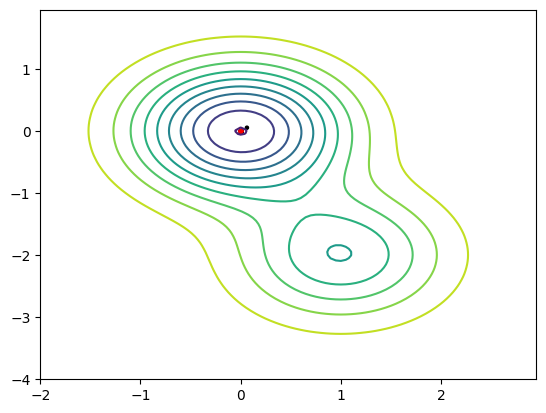

Population size       =  1000
Mutation probability  =  0.15
Crossover probability =  0.8
Num of iterations     =  50


In [6]:
func = lambda x, y: 1.5 - np.exp(-x ** (2) - y ** (2)) - 0.5 * np.exp(-(x - 1) ** (2) - (y + 2) ** (2))
gen = GeneticAlgorithm(64, 2, func, [[-2,3],[-4, 2]], 1000, 2, mutation_probability=0.15, crossover_probability=0.8, num_steps=50)
gen.run()

# mniejsza populacja

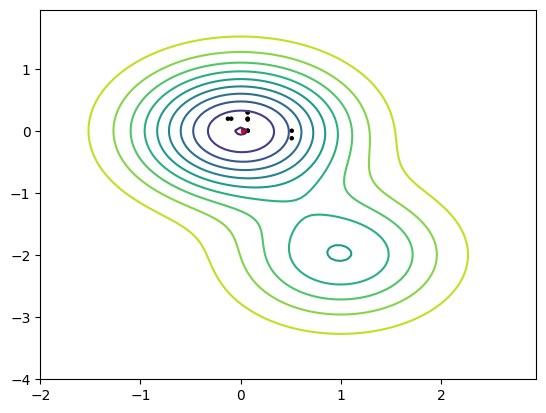

Population size       =  50
Mutation probability  =  0.25
Crossover probability =  0.8
Num of iterations     =  100


In [7]:
func = lambda x, y: 1.5 - np.exp(-x ** (2) - y ** (2)) - 0.5 * np.exp(-(x - 1) ** (2) - (y + 2) ** (2))
gen = GeneticAlgorithm(64, 2, func, [[-2,3],[-4, 2]], 50, 2, mutation_probability=0.25, crossover_probability=0.8, num_steps=100)
gen.run()

# większa długość chromosomu

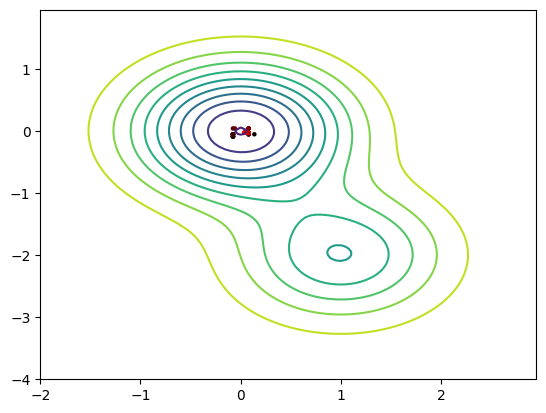

Population size       =  200
Mutation probability  =  0.15
Crossover probability =  0.8
Num of iterations     =  50
aoi                   =  [[-2, 3], [-4, 2]]
Chromosome length     =  1024


In [8]:
func = lambda x, y: 1.5 - np.exp(-x ** (2) - y ** (2)) - 0.5 * np.exp(-(x - 1) ** (2) - (y + 2) ** (2))
gen2 = GeneticAlgorithm(1024, 2, func, [[-2,3],[-4, 2]], 200, 2, mutation_probability=0.15, crossover_probability=0.8, num_steps=50)
gen2.run(2)

# mniejsza długość chromosomu

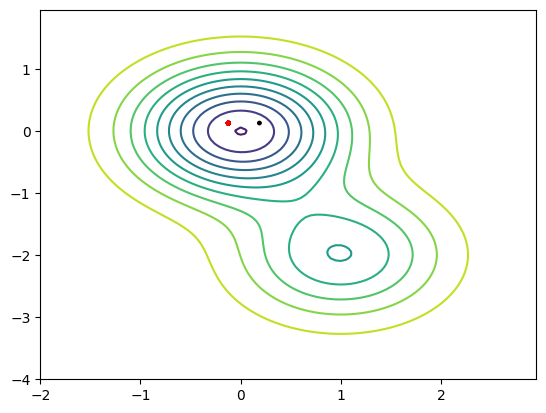

Population size       =  50
Mutation probability  =  0.15
Crossover probability =  0.8
Num of iterations     =  150
aoi                   =  [[-2, 3], [-4, 2]]
Chromosome length     =  8


In [9]:
func = lambda x, y: 1.5 - np.exp(-x ** (2) - y ** (2)) - 0.5 * np.exp(-(x - 1) ** (2) - (y + 2) ** (2))
gen2 = GeneticAlgorithm(8, 2, func, [[-2,3],[-4, 2]], 50, 2, mutation_probability=0.15, crossover_probability=0.8, num_steps=150)
gen2.run(2)

# większa dziedzina punktów

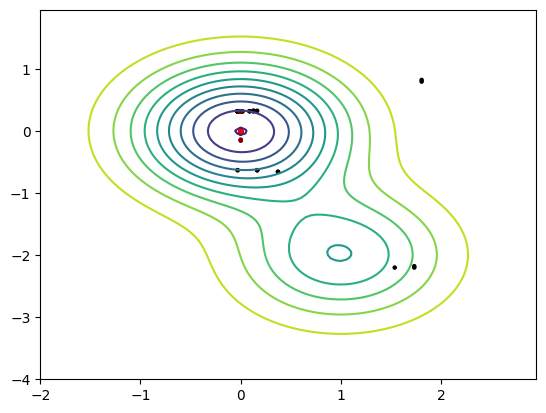

Population size       =  100
Mutation probability  =  0.75
Crossover probability =  0.8
Num of iterations     =  500
aoi                   =  [[-20, 30], [-40, 20]]
Chromosome length     =  128


In [10]:
func = lambda x, y: 1.5 - np.exp(-x ** (2) - y ** (2)) - 0.5 * np.exp(-(x - 1) ** (2) - (y + 2) ** (2))
gen2 = GeneticAlgorithm(128, 2, func, [[-20,30],[-40, 20]], 100, 2, mutation_probability=0.75, crossover_probability=0.8, num_steps=500)
gen2.run(2)

# wysoka mutacja

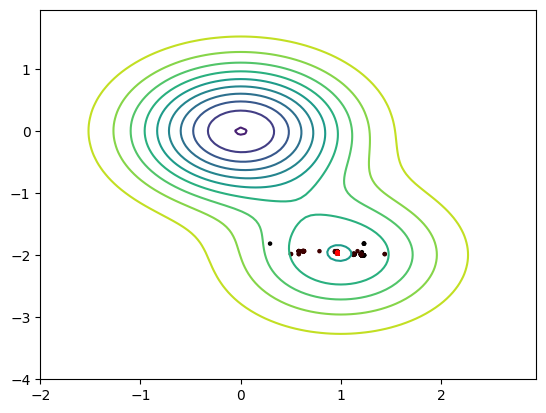

Population size       =  10
Mutation probability  =  0.75
Crossover probability =  0.8
Num of iterations     =  1000


In [11]:
func = lambda x, y: 1.5 - np.exp(-x ** (2) - y ** (2)) - 0.5 * np.exp(-(x - 1) ** (2) - (y + 2) ** (2))
gen2 = GeneticAlgorithm(128, 2, func, [[-2,3],[-4, 2]], 10, 2, mutation_probability=0.75, crossover_probability=0.8, num_steps=1000)
gen2.run()

# wnioski
Algorytm genetyczny ma szansę wyjść z minimum lokalnego, w przeciwieństwie do metody gradientowej, która zostanie w minimum lokalnym, dodatkowo algorytm genetyczny chodzi skokowo po całym wykresie, podczas gdy metoda gradientowa idzie do celu w jednej linii(krzywej). Czasowo algorytm genetyczny może wyjść gorzej, to zależy od parametrów